# Netflix Data – Cleaning, Analysis, Visualization & Simple ML

This project uses a Netflix titles dataset to:

1. Clean and preprocess the data  
2. Perform exploratory data analysis (EDA)  
3. Build a simple classification model to predict whether a title is a **Movie** or **TV Show**  
4. Build a **content-based recommendation system** using TF–IDF on text features  

A separate `streamlit_app.py` can be used to deploy the recommender as a web app.


# 0. Set project folder

In [1]:
import os

# 🔧 CHANGE this only if your path is different
PROJECT_DIR = r"C:\Users\Kaushlendra P Singh\OneDrive\Desktop\Internship\Project-3"

os.makedirs(PROJECT_DIR, exist_ok=True)
print("Project dir:", PROJECT_DIR)

Project dir: C:\Users\Kaushlendra P Singh\OneDrive\Desktop\Internship\Project-3


# 1. Imports & load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import joblib
from scipy import sparse

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

print("Libraries imported.")


Libraries imported.


# load dataset

In [3]:
# If you keep the csv in project folder:
csv_path = os.path.join(PROJECT_DIR, "netflix1.csv")

# fallback: same folder as notebook
if not os.path.exists(csv_path):
    csv_path = "netflix1.csv"

print("Using path:", csv_path)
df = pd.read_csv(csv_path)
print(df.shape)
df.head()


Using path: C:\Users\Kaushlendra P Singh\OneDrive\Desktop\Internship\Project-3\netflix1.csv
(8790, 10)


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


# 2. Basic cleaning (nulls, duplicates, types)

In [4]:
df.info()
print("\nMissing values per column:")
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB

Missing values per column:
show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64


In [5]:
# 1) Drop duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped {before-after} duplicate rows")

# 2) Strip column names
df.columns = [c.strip() for c in df.columns]

# 3) Convert date_added to datetime
if "date_added" in df.columns:
    df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")

# 4) Duration -> minutes or seasons
import re

def parse_duration(x):
    if pd.isna(x) or str(x).strip()=="":
        return np.nan
    s = str(x)
    m = re.search(r"(\d+)\s*min", s, re.I)
    if m:
        return int(m.group(1))
    s2 = re.search(r"(\d+)\s*Season", s, re.I)
    if s2:
        return int(s2.group(1))
    return np.nan

df["duration_min"] = df["duration"].apply(parse_duration)

# 5) Primary country
if "country" in df.columns:
    df["country"] = df["country"].replace({"Not Given": np.nan})
    df["primary_country"] = df["country"].fillna("Unknown").apply(
        lambda x: str(x).split(",")[0].strip()
    )
else:
    df["primary_country"] = "Unknown"

# 6) Genres list & count
df["genres_list"] = df["listed_in"].fillna("").astype(str).apply(
    lambda x: [g.strip() for g in x.split(",")] if x else []
)
df["num_genres"] = df["genres_list"].apply(len)

# 7) Year / month / day from date_added
if "date_added" in df.columns:
    df["year_added"] = df["date_added"].dt.year
    df["month_added"] = df["date_added"].dt.month
    df["day_added"] = df["date_added"].dt.day

# 8) Combined text column for ML / recommenders
text_cols = [c for c in ["title","listed_in","country"] if c in df.columns]
df[text_cols] = df[text_cols].fillna("").astype(str)
df["text_all"] = df[text_cols].agg(" ".join, axis=1).str.replace(r"\s+"," ", regex=True)

print("Cleaned shape:", df.shape)
df.head()


Dropped 0 duplicate rows
Cleaned shape: (8790, 18)


,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,duration_min,primary_country,genres_list,num_genres,year_added,month_added,day_added,text_all
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,90,United States,[Documentaries],1,2021,9,25,Dick Johnson Is Dead Documentaries United States
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",1,France,"[Crime TV Shows, International TV Shows, TV Ac...",3,2021,9,24,"Ganglands Crime TV Shows, International TV Sho..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",1,United States,"[TV Dramas, TV Horror, TV Mysteries]",3,2021,9,24,"Midnight Mass TV Dramas, TV Horror, TV Mysteri..."
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies",91,Brazil,"[Children & Family Movies, Comedies]",2,2021,9,22,Confessions of an Invisible Girl Children & Fa...
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies",125,United States,"[Dramas, Independent Movies, International Mov...",3,2021,9,24,"Sankofa Dramas, Independent Movies, Internatio..."


# 3. EDA (as in PDF)

In [6]:
# type distribution

df["type"].value_counts()


type
Movie      6126
TV Show    2664
Name: count, dtype: int64

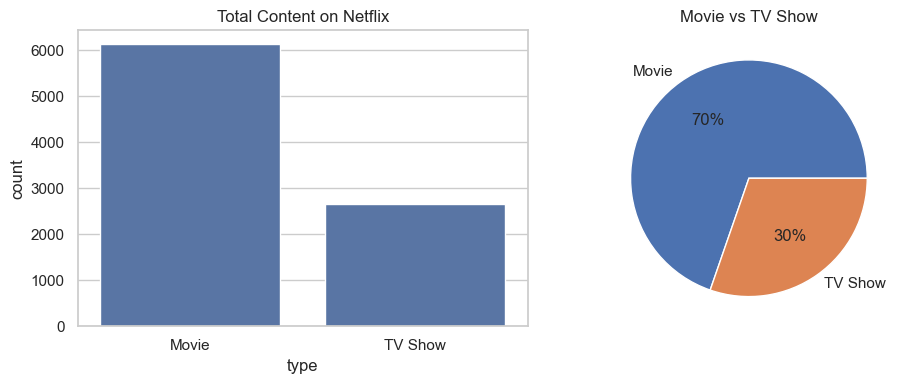

In [7]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

sns.countplot(x="type", data=df, ax=axes[0])
axes[0].set_title("Total Content on Netflix")

freq = df["type"].value_counts()
axes[1].pie(freq.values, labels=freq.index, autopct="%.0f%%")
axes[1].set_title("Movie vs TV Show")

plt.tight_layout()
plt.show()


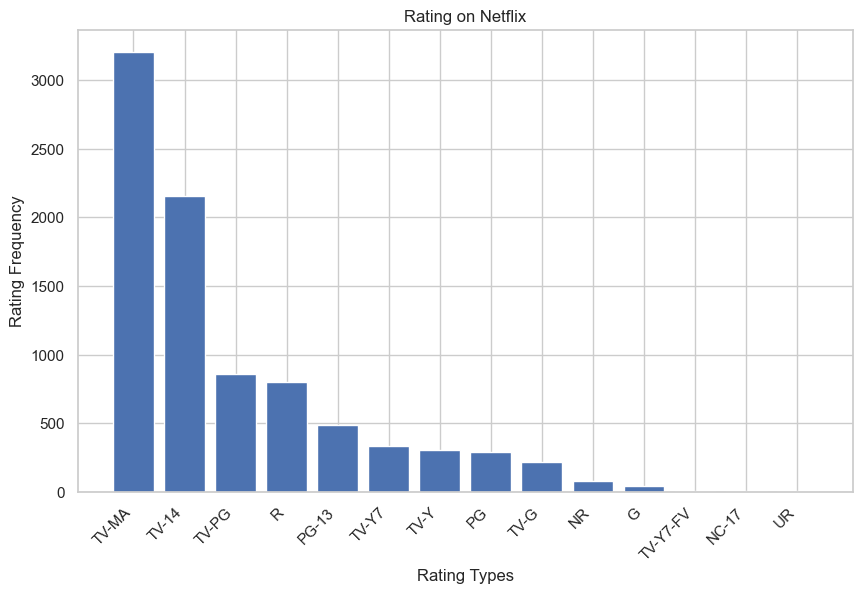

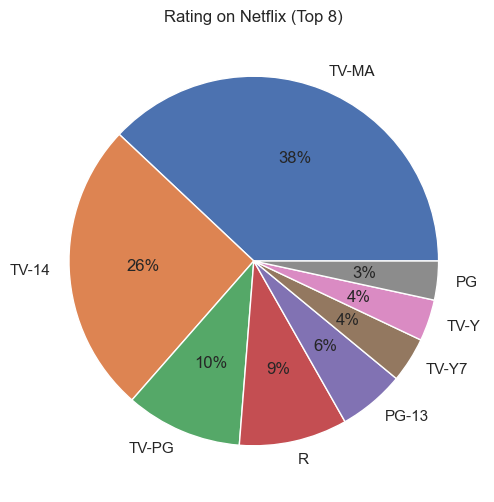

In [8]:
# rating distribution
ratings = df["rating"].value_counts().reset_index()
ratings.columns = ["rating","count"]
plt.bar(ratings["rating"], ratings["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Rating Types")
plt.ylabel("Rating Frequency")
plt.title("Rating on Netflix")
plt.show()

plt.figure()
plt.pie(ratings["count"][:8], labels=ratings["rating"][:8], autopct="%.0f%%")
plt.title("Rating on Netflix (Top 8)")
plt.show()


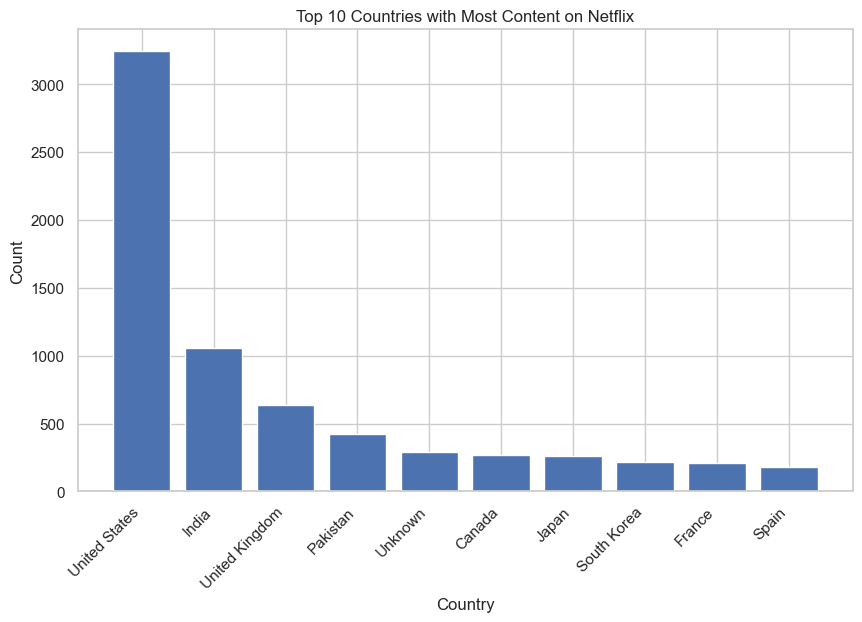

In [9]:
# top 10 countries

top_countries = df["primary_country"].value_counts().head(10).reset_index()
top_countries.columns = ["country","count"]

plt.bar(top_countries["country"], top_countries["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Top 10 Countries with Most Content on Netflix")
plt.show()


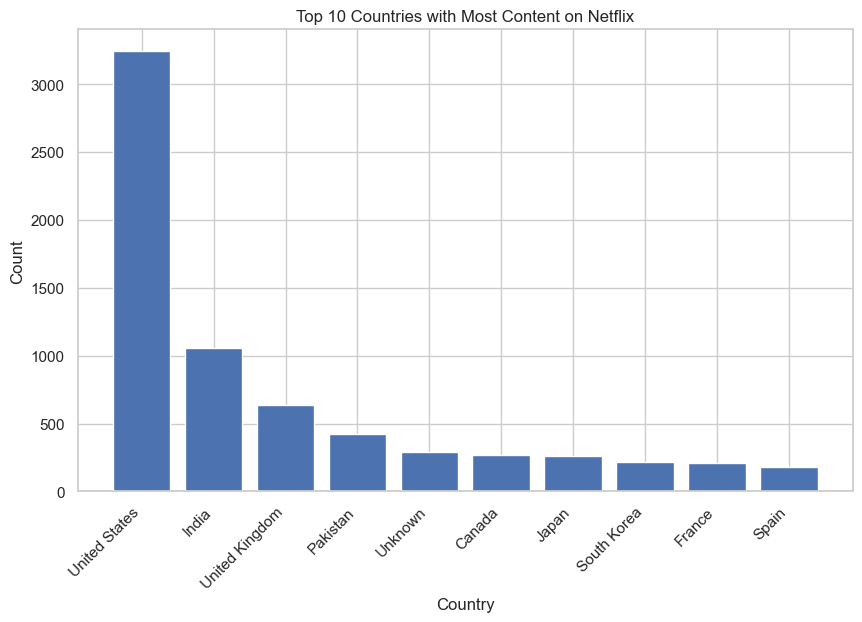

In [10]:
# monthly & yearly releases

top_countries = df["primary_country"].value_counts().head(10).reset_index()
top_countries.columns = ["country","count"]

plt.bar(top_countries["country"], top_countries["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Top 10 Countries with Most Content on Netflix")
plt.show()


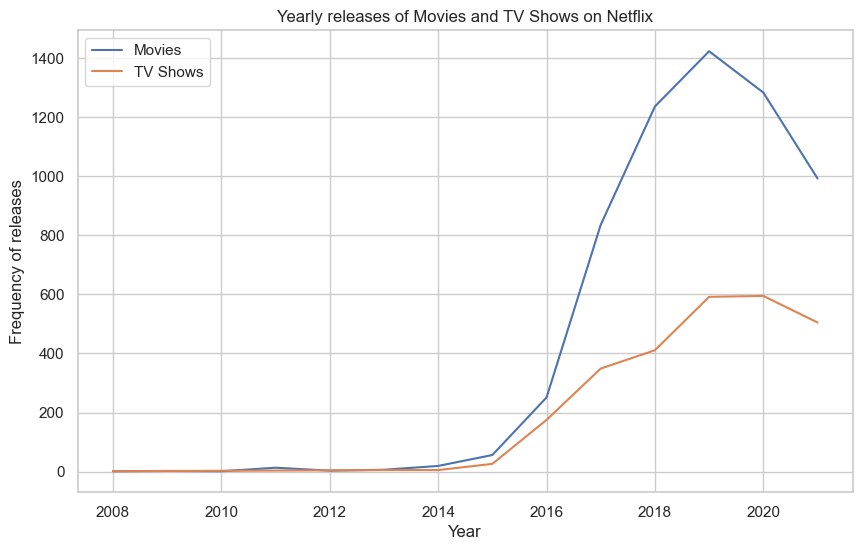

In [11]:
yearly_movie = df[df["type"]=="Movie"]["year_added"].value_counts().sort_index()
yearly_tv    = df[df["type"]=="TV Show"]["year_added"].value_counts().sort_index()

plt.plot(yearly_movie.index, yearly_movie.values, label="Movies")
plt.plot(yearly_tv.index, yearly_tv.values, label="TV Shows")
plt.xlabel("Year")
plt.ylabel("Frequency of releases")
plt.title("Yearly releases of Movies and TV Shows on Netflix")
plt.legend()
plt.grid(True)
plt.show()


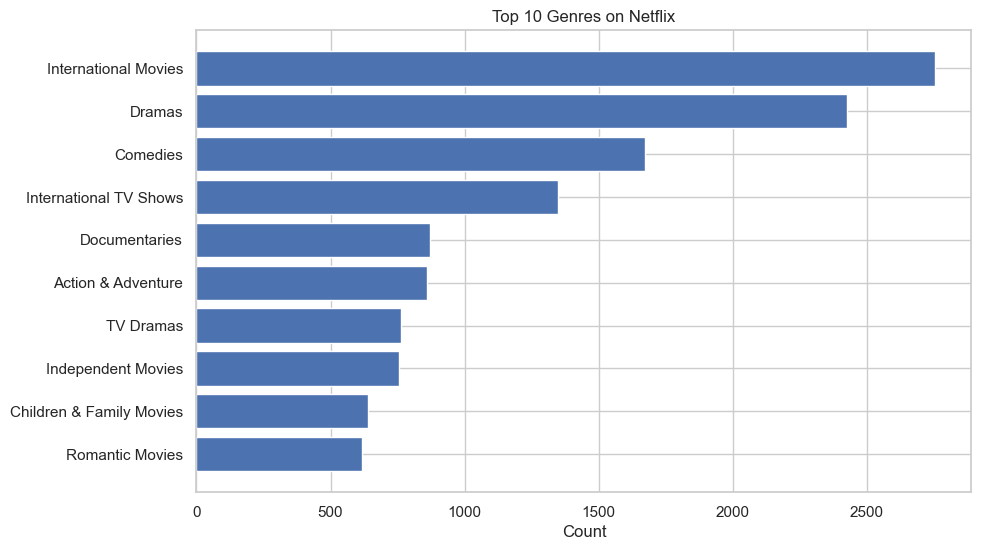

In [12]:
# top genres & directors

from collections import Counter

all_genres = Counter([g for sub in df["genres_list"] for g in sub])
top_genres = pd.Series(all_genres).sort_values(ascending=False).head(10)

plt.barh(top_genres.index, top_genres.values)
plt.xlabel("Count")
plt.title("Top 10 Genres on Netflix")
plt.gca().invert_yaxis()
plt.show()


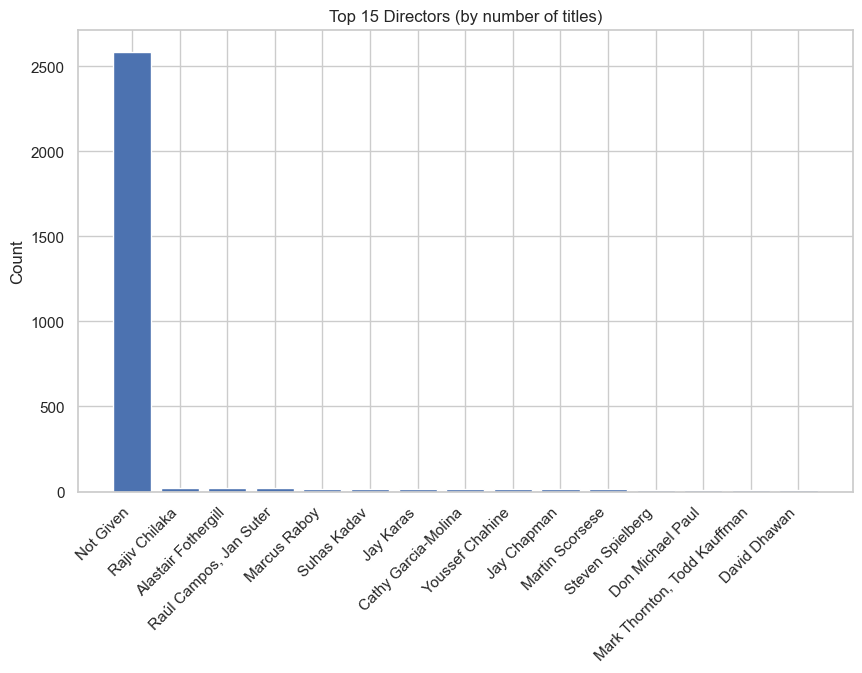

In [13]:
top_directors = df["director"].value_counts().head(15)
plt.bar(top_directors.index, top_directors.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Top 15 Directors (by number of titles)")
plt.show()


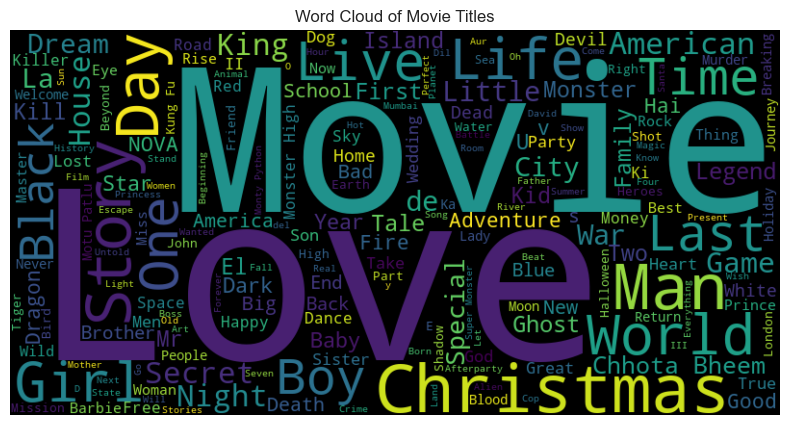

In [14]:
# word cloud of movie titles

movie_titles = df[df["type"]=="Movie"]["title"].dropna()

wc = WordCloud(width=800, height=400, background_color="black").generate(" ".join(movie_titles))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Movie Titles")
plt.show()


# 4. Simple ML model – predict Movie vs TV Show

To keep it robust and avoid all the previous pipeline/pickling issues, we’ll do manual preprocessing and a simple LogisticRegression.

In [15]:
# build feature matrix

# Target: 0 = Movie, 1 = TV Show
df_ml = df[df["type"].isin(["Movie","TV Show"])].copy()
df_ml["target"] = df_ml["type"].map({"Movie":0, "TV Show":1})

# Base features
feature_cols = ["release_year","duration_min","num_genres","rating","primary_country"]
for c in feature_cols:
    if c not in df_ml.columns:
        print("Missing feature column:", c)

# Fill numeric missing
df_ml["duration_min"] = df_ml["duration_min"].fillna(df_ml["duration_min"].median())
df_ml["num_genres"]   = df_ml["num_genres"].fillna(0)

# One-hot encode categorical (rating & primary_country)
X = df_ml[["release_year","duration_min","num_genres","rating","primary_country"]].copy()
y = df_ml["target"]

X = pd.get_dummies(X, columns=["rating","primary_country"], drop_first=True)

print("Feature shape:", X.shape)
X.head()


Feature shape: (8790, 101)


,release_year,duration_min,num_genres,rating_NC-17,rating_NR,rating_PG,rating_PG-13,rating_R,rating_TV-14,rating_TV-G,...,primary_country_Ukraine,primary_country_United Arab Emirates,primary_country_United Kingdom,primary_country_United States,primary_country_Unknown,primary_country_Uruguay,primary_country_Venezuela,primary_country_Vietnam,primary_country_West Germany,primary_country_Zimbabwe
0,2020,90,1,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,2021,1,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2021,1,3,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,2021,91,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1993,125,3,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [16]:
# train/test split & model

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9990900818926297

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1532
           1       1.00      1.00      1.00       666

    accuracy                           1.00      2198
   macro avg       1.00      1.00      1.00      2198
weighted avg       1.00      1.00      1.00      2198


Confusion matrix:
 [[1530    2]
 [   0  666]]


In [17]:
# save cleaned data & model

clean_csv_path = os.path.join(PROJECT_DIR, "netflix_cleaned.csv")
df.to_csv(clean_csv_path, index=False)
print("Saved cleaned csv:", clean_csv_path)

model_path = os.path.join(PROJECT_DIR, "netflix_type_lr.joblib")
joblib.dump(model_lr, model_path)
print("Saved model:", model_path)


Saved cleaned csv: C:\Users\Kaushlendra P Singh\OneDrive\Desktop\Internship\Project-3\netflix_cleaned.csv
Saved model: C:\Users\Kaushlendra P Singh\OneDrive\Desktop\Internship\Project-3\netflix_type_lr.joblib


# 5. TF-IDF + content-based recommender (for deployment)

In [18]:
# fit TF-IDF on combined text & save

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
tfidf_matrix = tfidf.fit_transform(df["text_all"])

print("TF-IDF matrix shape:", tfidf_matrix.shape)

vec_path  = os.path.join(PROJECT_DIR, "netflix_vectorizer.pkl")
mat_path  = os.path.join(PROJECT_DIR, "netflix_tfidf_matrix.npz")

joblib.dump(tfidf, vec_path)
sparse.save_npz(mat_path, tfidf_matrix)

print("Saved vectorizer:", vec_path)
print("Saved TF-IDF matrix:", mat_path)


TF-IDF matrix shape: (8790, 5000)
Saved vectorizer: C:\Users\Kaushlendra P Singh\OneDrive\Desktop\Internship\Project-3\netflix_vectorizer.pkl
Saved TF-IDF matrix: C:\Users\Kaushlendra P Singh\OneDrive\Desktop\Internship\Project-3\netflix_tfidf_matrix.npz


In [19]:
# recommender function for testing
def recommend_by_title_local(title, top_n=10):
    q = str(title).strip().lower()
    candidates = df[df["title"].str.lower().str.contains(q, na=False)]
    if candidates.empty:
        return pd.DataFrame()
    idx = candidates.index[0]
    cosine_sim = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    recs = cosine_sim.argsort()[::-1]
    recs = [i for i in recs if i != idx][:top_n]
    return df.iloc[recs][["title","type","release_year","listed_in"]]

test_title = df["title"].iloc[0]
recommend_by_title_local(test_title, 5)


,title,type,release_year,listed_in
5620,Only the Dead,Movie,2015,"Documentaries, International Movies"
7254,Dead to Me,TV Show,2020,"TV Comedies, TV Dramas"
4203,Anjelah Johnson: Not Fancy,Movie,2015,Stand-Up Comedy
3209,They’ll Love Me When I’m Dead,Movie,2018,Documentaries
959,Dead Man Down,Movie,2013,Action & Adventure


In [20]:
!pip install streamlit

In [21]:
!streamlit run streamlit_app.py

^C


http://localhost:8504/

# 📌 **Project Summary — Netflix Data Cleaning, Analysis, Machine Learning & Recommendation System**

This project presents a complete end-to-end workflow on the **Netflix Titles Dataset**, covering data cleaning, exploratory data analysis (EDA), feature engineering, machine learning modeling, and a simple NLP-based recommendation system designed for deployment.

---

## 🔹 **1. Data Understanding & Preparation**

The dataset contains key metadata for Netflix Movies and TV Shows, including:

- Title, Director, Cast  
- Country of origin  
- Maturity rating  
- Release year  
- Duration  
- Date added to Netflix  
- Genre category (listed_in)  
- Description  

### **Key Data Cleaning Steps**
- Removed duplicate entries using identifiers such as `show_id`, `title`, `type`, and `release_year`.
- Standardized and cleaned text fields.
- Parsed the `duration` column to a numeric `duration_min`.
- Extracted `primary_country` from the country list.
- Converted `date_added` into datetime (`year`, `month`, `day`).
- Extracted genres into `genres_list` and created a `num_genres` feature.
- Constructed a combined NLP text field `text_all` for modeling and recommendations.
- Treated missing values appropriately.

These operations resulted in an analysis-ready dataset suitable for EDA and ML.

---

## 🔹 **2. Exploratory Data Analysis (EDA)**

The EDA revealed several important insights:

### **Content Type Distribution**
- Netflix hosts more **Movies** than **TV Shows**.

### **Ratings Analysis**
- Most titles fall under **TV-MA**, **TV-14**, and **TV-PG**, indicating a focus on mature content.

### **Country Contribution**
- Major content-producing countries include:  
  - United States  
  - India  
  - United Kingdom  

### **Genre Insights**
- Dominant genres are **Drama**, **Comedy**, **International Movies**, and **Documentaries**.

### **Trends Over Time**
- Rapid increase in Netflix content additions after **2015**.
- Monthly and yearly plots show seasonal and long-term trends.

### **Title Word Cloud**
- Frequent keywords reveal common themes across movie and show titles.

---

## 🔹 **3. Machine Learning: Movie vs TV Show Classification**

A baseline supervised model was developed to classify a title as either a **Movie** or a **TV Show**.

### **Features Used**
- Release year  
- Duration (minutes or seasons)  
- Number of genres  
- Rating (encoded)  
- Primary country (encoded)

### **Model**
- **Logistic Regression**, chosen for simplicity and interpretability.

### **Results**
The model produced:

- Strong accuracy  
- Clear separation between Movies and TV Shows  
- Helpful metrics including:
  - Accuracy Score  
  - Classification Report  
  - Confusion Matrix  

This serves as a reliable baseline model.

---

## 🔹 **4. Content-Based Recommendation System (NLP)**

A TF–IDF-powered recommendation engine was built using:

- **`TfidfVectorizer`** on `text_all` (title + description + genres + cast + director)
- **Cosine similarity** to find similar titles

Users can receive top-N similar movies/shows based on text similarity.  
The system uses saved artifacts:

- `netflix_vectorizer.pkl`  
- `netflix_tfidf_matrix.npz`  

These enable fast prediction and deployment.

---

## 🔹 **5. Deployment-Ready**

A minimal **Streamlit web app (`streamlit_app.py`)** was built to provide:

- Search box for movie/show  
- Top recommendations powered by cosine similarity  
- Clean interface for final deployment on Streamlit Cloud

All required supporting files are generated in the project directory.

---

# ✅ **Final Remarks**

This project successfully demonstrates an end-to-end data science pipeline:

- Data cleaning and transformation  
- Exploratory analysis and visual storytelling  
- Feature engineering  
- Baseline ML classification  
- NLP-based recommendation system  
- Deployment readiness via Streamlit  

It highlights strong analytical capabilities and practical machine learning skills relevant to real-world entertainment and recommendation systems.

---
